# Introduction

For this project, I obtained the [weather values dataset](https://www.avoindata.fi/data/fi/dataset/saahavaintojen-vuorokausiarvot1/resource/2fdb6cd6-1a32-45ad-8af0-a2a8102cfeed) provided by the Finnish Meteorological Institute, for understanding the impact of climate change on the number of snow days over the years. Further details are described in the later sections.

In [1]:
import os
import pystan
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

os.environ["CC"] = "/usr/local/bin/gcc-9"
# just to be sure
os.environ["CXX"] = "/usr/local/bin/g++-9"

In [2]:
# Load and set up data
snow_days_data = np.loadtxt('snow_days_data.np')
x, y, l = snow_days_data
l = l.astype(int)
y = y.astype(int)
x = x.astype(int)
# Measurement locations 
loc_coords = np.loadtxt('measurement_locations.np')
loc_labels = np.loadtxt('measurement_loc_labels.np')

int_to_location = {1 : "Lapland", 2 : "North Fin", 3 : "South Fin", 4: "East Fin", 5 : "West Fin"}
int_to_color = {1 : "C0", 2 : "C1", 3 : "C2", 4: "C3", 5 : "C4"}

# Data exploration <a name="data"></a>

Upon obtaining the data, I cleaned and extracted the yearly number of snow days for different locations around Finland, since $1959$. I computed the number of days based on the values of snow depth on the ground. Additionally, I grouped these measurements into $5$ broad locations, i.e., Lapland, North, South, East, and West.

Notations for the dataset are defined in the cell below through an example. Besides, the geographic division of measurement stations is visualized in the form of a basemap and the distribution spread of data samples among the $5$ locations is represented in the form of scatter plots.

In [3]:
print("Data contains")
print("Year: x")
print("days with snow (during the year): y")
print("location: l")

print("\nExample of the data\n")
print("| \t x \t | \t y \t | \t l \t |")
print("| \t---\t | \t---\t | \t---\t |")
for i,j,k in zip(x[:5],y[:5],l[:5]):
    print("|\t{} \t |\t{} \t | \t {} \t |".format(i,j,k))

Data contains
Year: x
days with snow (during the year): y
location: l

Example of the data

| 	 x 	 | 	 y 	 | 	 l 	 |
| 	---	 | 	---	 | 	---	 |
|	1960 	 |	192 	 | 	 1 	 |
|	1961 	 |	171 	 | 	 1 	 |
|	1962 	 |	190 	 | 	 1 	 |
|	1963 	 |	191 	 | 	 1 	 |
|	1964 	 |	177 	 | 	 1 	 |



Locations are divided as follows
Lapland
North Fin
South Fin
East Fin
West Fin

Measurement stations are divided geographically as follows


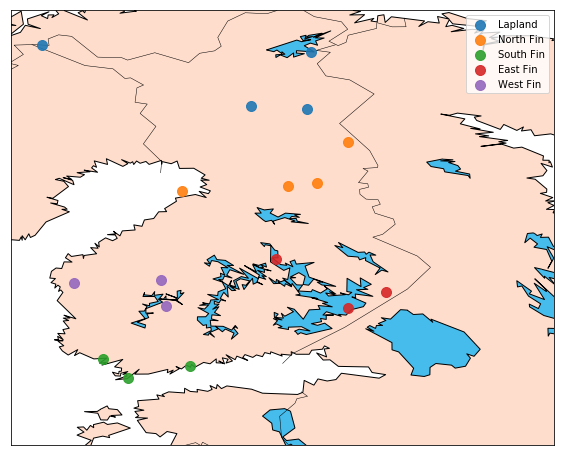

In [4]:
print("\nLocations are divided as follows")
for label in range(1, 6):
    print(int_to_location[label])
    
print("\nMeasurement stations are divided geographically as follows")
# Draw locations on the map
fig = plt.figure(figsize=(12, 8), edgecolor='w')
m = Basemap(projection='cyl', resolution="l", llcrnrlat=58, urcrnrlat=70, llcrnrlon=20, urcrnrlon=35, )
m.fillcontinents(color="#FFDDCC", lake_color='#46bcec')
m.drawcoastlines()
m.drawcountries()

stations = {}
for (lat, lot), label in zip(loc_coords, loc_labels):
    if label not in stations.keys():
        stations[label] = []    
    stations[label].append((lat, lot))

for label in range(1, 6):
    m.scatter([l for _,l in stations[label]], [l for l,_ in stations[label]], 
              latlon=True, color=int_to_color[label], s=100, alpha=0.9, zorder=5, label=int_to_location[label])
    

plt.legend()
plt.show()

In [5]:
print("Total samples: {}".format(len(y)))
for label in range(1, 6):
    print("theres {} samples from {}".format(len([i for i in l if i == label]), int_to_location[label]))

Total samples: 847
theres 171 samples from Lapland
theres 162 samples from North Fin
theres 172 samples from South Fin
theres 173 samples from East Fin
theres 169 samples from West Fin


Snow as function of year at different locations


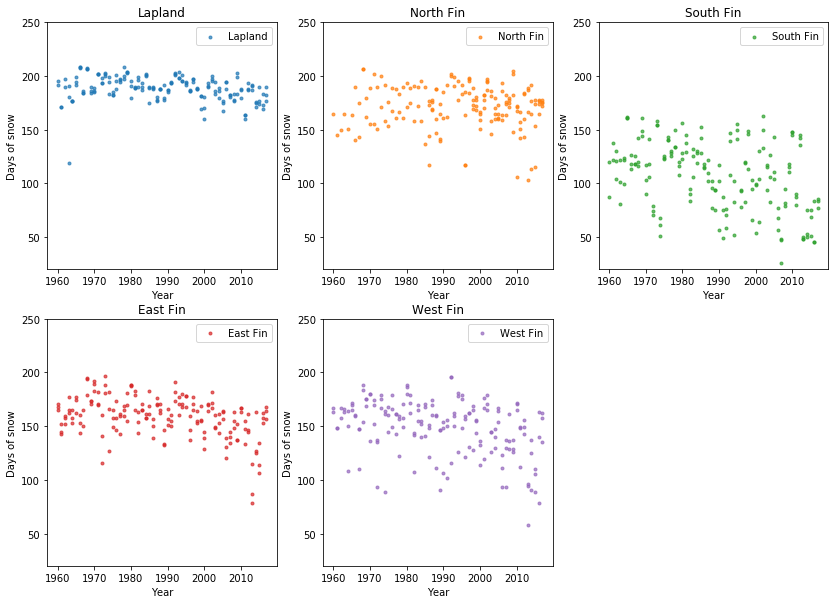

In [13]:
print("Snow as function of year at different locations")

# Plots for data at different locations
fig = plt.figure(figsize=(14,10))
for label in range(1, 6):
    
    my_fig = fig.add_subplot(2,3,label)
    my_fig.scatter([i for i,l in zip(x,l) if l == label],[i for i,l in zip(y,l) if l == label], 
                   color=int_to_color[label], label=int_to_location[label], marker=".", alpha=0.7)
    my_fig.legend()
    plt.ylim(20,250)
    plt.title(int_to_location[label])
    plt.ylabel("Days of snow")
    plt.xlabel("Year")
plt.show()

**Standardizing the data (in the cell below) to have zero mean for avoiding strong posterior dependency between the alpha and beta parameters of the model, that can result in sampling chains saturation leading to sub-optimal model behavior.**

In [14]:
# posterior predictive checking
xpred = (2019 - np.mean(x)) / np.std(x)

x_std = (x - np.mean(x)) / np.std(x)
y_std = (y - np.mean(y)) / np.std(y)

print(f'x_std sample: {x_std[0]:5f}, y_std sample: {y_std[0]:5f}, x_pred: {xpred}')

x_std sample: -1.817598, y_std sample: 1.050116, x_pred: 1.7626469961199116


In [15]:
max(x_std)

1.6412827717803138

# Analysis problem <a name="problem"></a>

My objective is to analyze the existence of a country-wide trend showing a decrease in the number of snow days.

For this purpose, I employed a linear regressor to fit the data that can model the number of snow days. Intuitively, conclusions can be drawn from the slope of the regressor as to the increase or decrease of the snow days.

# Model descriptions <a name="model"></a>

Assuming that the number of snow days follow a general linear fit:

$$y_i \sim N \left( \alpha + \beta x_i, \sigma \right)$$

where $y_i$ represents the number of days of now and $x_i$ represents the year. Slope $\beta$ of the posterior is the parameter of interest.

Two models are employed for the purpose of this analysis:

## Separate Model

In a `Separate nodel`, the assumption is that the locations are independent and do not follow a common trend. Consequently, slope for each location is attained from its own distribution.


$$
y_{\{i,loc\}} \sim N \left( \alpha_{loc} + \beta_{loc} x_{\{i,loc\}}, \sigma_{loc} \right), \text{where } \\
\alpha, \beta \text{ are location specific separate parameters.}
$$

## Hierarchical Model

In a `Hierarchical model`, the assumption is that there exists a country-wide trend and therefore the slope for every location is attained from a common distribution.

$$
y_{\{i,loc\}} \sim N \left( \alpha_{loc} + \beta_{loc} x_{i,loc}, \sigma \right), \\
\beta \sim N \left( \mu_b, \sigma_b \right)
$$

# Choice of priors <a name="priors"></a>

### For `separate model`:

From the location-based scatter plots, a change in the number of snow days is evident. Specifically, for `Lapland` the trend is less extreme compared to the `South Fin` location. Relying on these imminent differences, pirors for each location is assumed. They are the as follows:

- `Lapland`: $N \left( -0.2, 1 \right)$
- `North Fin`: $N \left( -0.5, 1 \right)$
- `South Fin`: $N \left( -1.5, 1 \right)$
- `East Fin`: $N \left( -1.0, 1 \right)$
- `West Fin`: $N \left( -1.0, 1 \right)$

### For `hierarchical model`:

Given that the slopes for every location ($\beta$s) are obtained from a common distribution, we define uniform priors for the mean and standard deviation of this distribution. They are formulated as follows:

$$
\mu_b \sim U \left( -1, 1 \right),  \\
\sigma_b \sim U \left( 0, 1 \right), \\
\beta \sim N \left( \mu_b, \sigma_b \right)
$$

Based on similar analysis provided for the separate model priors, the mean ($\mu_b$) of the hierarchical model is assumed to uniformly lie between -1 and 1 emphasizing the lack of information when considering all the locations together. Same motivations apply for the deviation $\sigma_b$.

In [16]:
separate_model = """
data {
    int<lower=0> P; 
    int<lower=0> N; 
    int<lower=1,upper=P> location[N];
    vector[N] x;
    vector[N] y;
    vector[P] beta_prior;
    real xpred;
}
parameters {
    vector[P] alpha;
    vector[P] beta;
    vector[P] sigma_y;
    // real<lower=0> sigma_y;
}
transformed parameters {
    vector[N] mu;
    for (i in 1:N)
        mu[i] = alpha[location[i]] + beta[location[i]] * x[i];
}
model {
    for (i in 1:N)
        y[i] ~ normal(mu[i], sigma_y[location[i]]);
        
    for (k in 1:P)
        beta[k] ~ normal(beta_prior[k], 1);
}
generated quantities {
    vector[N] log_likelihood;
    real ypred[P];
    
    for (k in 1:P)
        ypred[k] = normal_rng(alpha[k] + beta[k] * xpred, sigma_y[k]);

    for (i in 1:N)
        log_likelihood[i] = normal_lpdf(y[i] | mu[i], sigma_y[location[i]]);
}
"""

In [17]:
data = {
    'N': len(y_std),
    'P': max(l),
    'x': x_std,
    'y': y_std,
    'location': l,
    'beta_prior' : [-0.2, -0.5, -1.5, -1.0, -1.0],
    'xpred': xpred
}
sm = pystan.StanModel(model_code=separate_model)
separate_fit = sm.sampling(data=data, iter=3000, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_33c33ddec91c7b2c8c75bcb18113546e NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [18]:
inference_data = az.from_pystan(posterior=separate_fit, log_likelihood="log_likelihood")
p_loo = az.loo(inference_data, pointwise=True, scale="log")
print(p_loo)

Computed from 4500 by 847 log-likelihood matrix

         Estimate       SE
elpd_loo  -701.78    35.66
p_loo       22.64        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      846   99.9%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1    0.1%



/Users/jukkapajunen/miniconda3/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


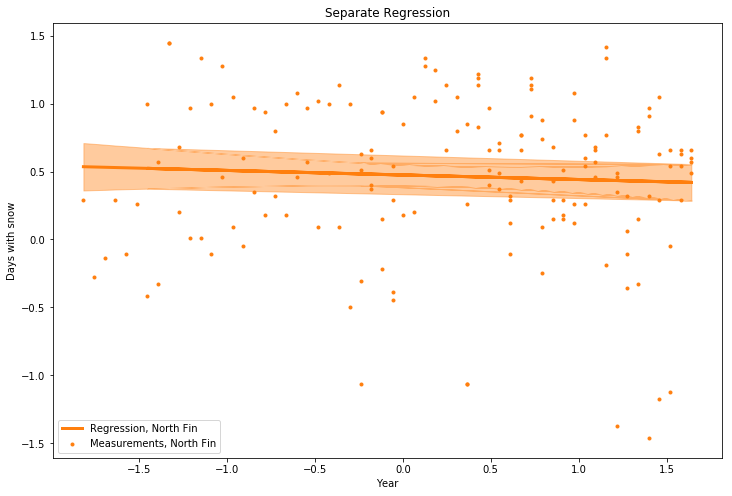

In [20]:
plt.figure(figsize=(12,8))
plt.title("Separate Regression")
for target_label in range(2, 3):
    # Plot the existing data
    x_tmp = []
    y_tmp = []
    for year, data, label in zip(x_std, y_std, l):    
        if label == target_label:
            x_tmp.append(year)
            y_tmp.append(data)
    plt.scatter(x_tmp, y_tmp, 
        label="Measurements, {}".format(int_to_location[target_label]), marker=".", 
        color=int_to_color[target_label])

    # Plot the regression result
    line_x = []
    line_data = []
    for i, label in enumerate(l):
        if label == target_label:
            line_data.append(separate_fit["mu[{}]".format(i + 1)])
            line_x.append(x_std[i])

    plt.fill_between(line_x, np.percentile(line_data, 5, axis=1),
                     np.percentile(line_data, 95, axis=1),
                     color=int_to_color[target_label], 
                     alpha=0.4)

    plt.plot(line_x, np.percentile(line_data, 50, axis=1), linewidth=3, 
             label="Regression, {}".format(int_to_location[target_label]), 
             color=int_to_color[target_label])

# plt.ylim(50, 250)
plt.xlabel("Year")
plt.ylabel("Days with snow")
plt.legend()
plt.show()

In [21]:
hierarchical_model = """
data {
    int<lower=0> P; 
    int<lower=0> N; 
    int<lower=1,upper=P> location[N];
    vector[N] x;
    vector[N] y;
    real xpred;
}
parameters {
    vector[P] alpha;
    vector[P] beta;
    real mu_b;
    real sigma_b;
    // real<lower=0> sigma_y[P];
    real<lower=0> sigma_y;
}
transformed parameters {
    vector[N] mu;
    for (i in 1:N)
        mu[i] = alpha[location[i]] + beta[location[i]] * x[i];
}
model {
    y ~ normal(mu, sigma_y);
    
    sigma_b ~ uniform(0, 2);
    mu_b ~ uniform(-2, 2);
    beta ~ normal(mu_b, sigma_b);
}
generated quantities {
    vector[N] log_likelihood;
    real ypred[P];
    for (i in 1:P)
        ypred[i] = normal_rng(alpha[i] + beta[i] * xpred, sigma_y);

    for (i in 1:N)
        log_likelihood[i] = normal_lpdf(y[i] | mu[i], sigma_y);
}
"""

In [22]:
data = {
    'N': len(y),
    'P': max(l),
    'x': x_std,
    'y': y_std,
    'location': l,
    'xpred': xpred
}
sm = pystan.StanModel(model_code=hierarchical_model)
fit_h = sm.sampling(data=data, iter=3000, chains=5)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6d544c46cfba0e896540ef6de671e7a NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [23]:
inference_data_h = az.from_pystan(posterior=fit_h, log_likelihood="log_likelihood")
p_loo_h = az.loo(inference_data_h, pointwise=True, scale="log")
print(p_loo_h)

Computed from 7500 by 847 log-likelihood matrix

         Estimate       SE
elpd_loo  -774.19    25.85
p_loo       11.82        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      847  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



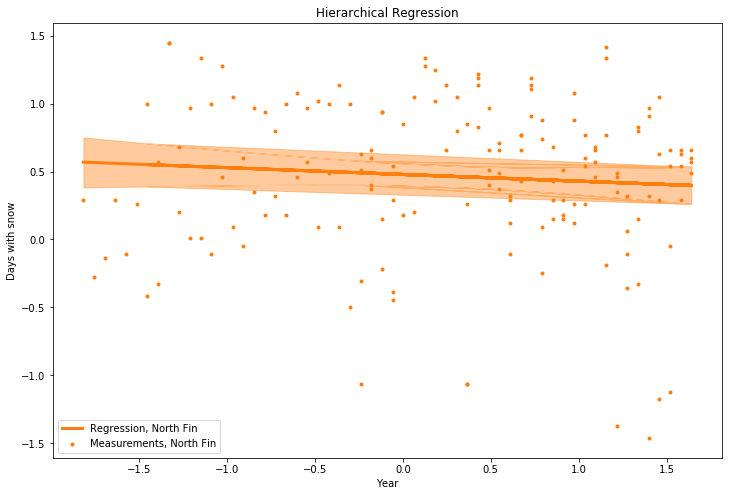

In [24]:
plt.figure(figsize=(12,8))
plt.title("Hierarchical Regression")
for target_label in range(2, 3):
    # Plot the existing data
    x_tmp = []
    y_tmp = []
    for year, data, label in zip(x_std, y_std, l):    
        if label == target_label:
            x_tmp.append(year)
            y_tmp.append(data)
    plt.scatter(x_tmp, y_tmp, 
        label="Measurements, {}".format(int_to_location[target_label]), marker=".", 
        color=int_to_color[target_label])

    # Plot the regression result
    line_x = []
    line_data = []
    for i, label in enumerate(l):
        if label == target_label:
            line_data.append(fit_h["mu[{}]".format(i + 1)])
            line_x.append(x_std[i])

    plt.fill_between(line_x, np.percentile(line_data, 5, axis=1),
                     np.percentile(line_data, 95, axis=1),
                     color=int_to_color[target_label], 
                     alpha=0.4)

    plt.plot(line_x, np.percentile(line_data, 50, axis=1), linewidth=3, 
             label="Regression, {}".format(int_to_location[target_label]), 
             color=int_to_color[target_label])

# plt.ylim(50, 250)
plt.xlabel("Year")
plt.ylabel("Days with snow")
plt.legend()
plt.show()

# Diagnostics <a name="diagnostics"></a>

In [25]:
pystan.check_hmc_diagnostics(separate_fit, verbose=3)

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1.02) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.03) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.15) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

`n_eff` being true, indicates that the estimated effective sample sizes for all the parameters are high resulting in a low standard error and more stable model behavior.

`Rhat` being true indicates that it is close to $\sim 1.0$ signifying convergence of the simulated chains.

`divergence` being true indicates that the target posterior is fully explored during simulation without imblance between the chains.

`treedepth` being true indicates that none of the iterations saturated at a depth pre-convergence.

In [26]:
pystan.check_hmc_diagnostics(fit_h, verbose=3)

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.949) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.854) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.893) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.901) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 5: E-BFMI (= 0.773) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': True,
 'energy': True}

`n_eff` being true, indicates that the estimated effective sample sizes for all the parameters are high resulting in a low standard error and more stable model behavior.

`Rhat` being true indicates that it is close to $\sim 1.0$ signifying convergence of the simulated chains.

`divergence` being False indicates that the target posterior isn't fully explored during simulation owing to the variation of data between locations.

`treedepth` being true indicates that none of the iterations saturated at a depth pre-convergence.

`elpd_loo  -701.60` for the separate model and `elpd_loo  -774.24` for the hierarchical model indicate that separate model is a better fit for this data.

Although the separate model resulted in one `Pareto-K` split as bad, it can be ignored as a case of an outlier (`1` sample out of `847`).

# Discussion <a name="discussion"></a>

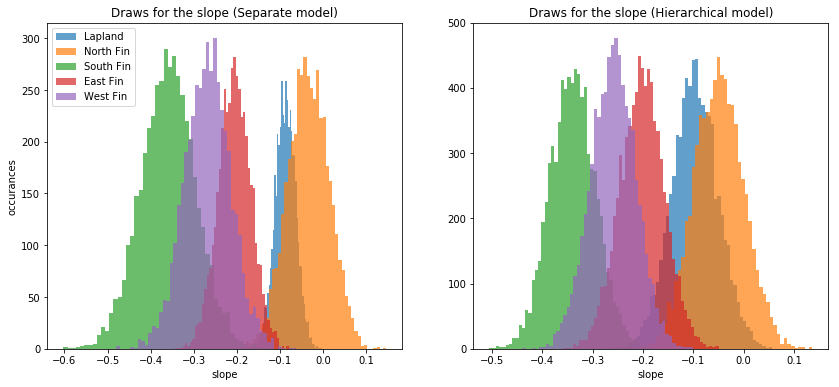

In [27]:
fig = plt.figure(figsize=(14,6))

plt.subplot(1, 2, 2)

plt.title("Draws for the slope (Hierarchical model)")

for label in range(1, 6):
    plt.hist(fit_h["beta[{}]".format(label)], bins=50, linewidth=2, label=int_to_location[label], alpha=0.7)
    
plt.xlabel('slope')
    
plt.subplot(1, 2, 1)

plt.title("Draws for the slope (Separate model)")

for label in range(1, 6):
    plt.hist(separate_fit["beta[{}]".format(label)], bins=50, linewidth=2, label=int_to_location[label], alpha=0.7)

plt.xlabel('slope')
plt.ylabel('occurances')

plt.legend()
plt.show()

According to the visualizations of slopes of both the models, it is evident that there is a general trend of snow days is decreasing. `South Fin` location shows a more prominent decrease relative to other locations. On the other hand, `Lapland` and `North Fin` locations show lesser signs of decrease.

**ALERT: Predictions for this winter (2019) by both the models. You're welcome!**

In [28]:
posterior_preds = np.mean(separate_fit['ypred'], axis=0)
posterior_preds = (posterior_preds * np.std(y)) + np.mean(y)

for i in range(1,6):
    print(f'Location: {int_to_location[i]} will have {int(round(posterior_preds[i-1]))} number of snow days according to the separate model.')

Location: Lapland will have 183 number of snow days according to the separate model.
Location: North Fin will have 169 number of snow days according to the separate model.
Location: South Fin will have 84 number of snow days according to the separate model.
Location: East Fin will have 146 number of snow days according to the separate model.
Location: West Fin will have 131 number of snow days according to the separate model.


In [29]:
posterior_preds = np.mean(fit_h['ypred'], axis=0)
posterior_preds = (posterior_preds * np.std(y)) + np.mean(y)

for i in range(1,6):
    print(f'Location: {int_to_location[i]} will have {int(round(posterior_preds[i-1]))} number of snow days according to the hierarchical model.')

Location: Lapland will have 182 number of snow days according to the hierarchical model.
Location: North Fin will have 168 number of snow days according to the hierarchical model.
Location: South Fin will have 85 number of snow days according to the hierarchical model.
Location: East Fin will have 146 number of snow days according to the hierarchical model.
Location: West Fin will have 132 number of snow days according to the hierarchical model.


# Conclusions <a name="discussion"></a>

Through this project, I demonstrated the trend of number of snow days across Finland. I followed the standard Bayesian workflow by analyzing the data and fitting two distinct models.

Upon understanding the diagnostics and dicussing the posteriors obtained, I can conclude that the number of winter days is decreasing in general.

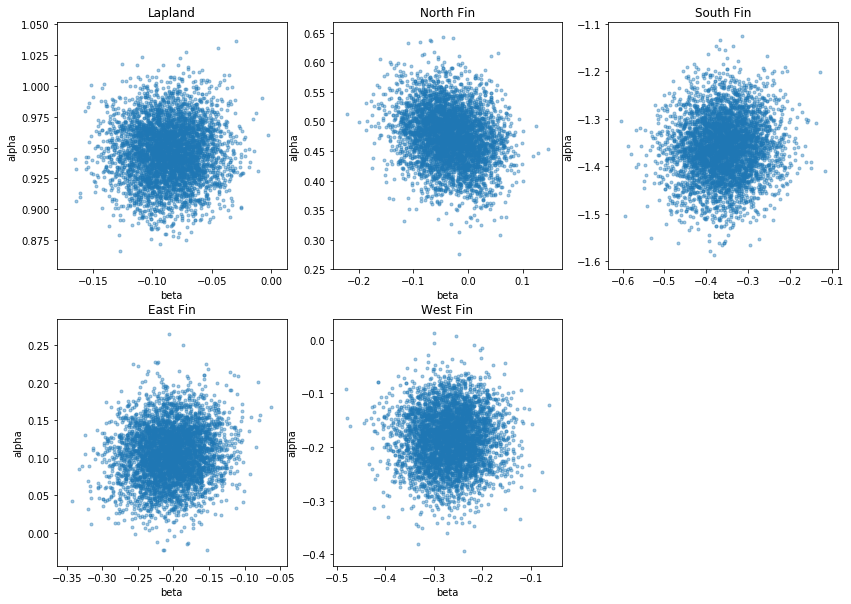

In [30]:
plt.figure(figsize=(14,10))
plt.title("Alpha to Beta")

for i in range(1,6):
    plt.subplot(2,3,i)
    plt.title(int_to_location[i])
    plt.scatter(separate_fit["beta[{}]".format(i)], separate_fit["alpha[{}]".format(i)], marker=".", alpha=0.4)
    plt.xlabel("beta")
    plt.ylabel("alpha")

plt.show()